In [3]:
import os
import sys
import random

import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import keras

from keras.metrics import MeanIoU
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from  keras_preprocessing.image   import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, schedules, Adam
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.models import Model, load_model
from tensorflow.python.keras import losses

In [4]:
dpath = "Dataset_BUSI\Dataset_BUSI_with_GT/"

In [5]:
data = {'image' : [],
        'mask' : []}
classes = ['benign', 'malignant', 'normal']
image_height = 256
image_width = 256

In [6]:
def load_data(path, data_obj, class_name):
    img_names_list = os.listdir(path+class_name)
    image_names = []
    mask_names = []
    names_truncated = []
    
    for i in range(len(img_names_list)):
        names_truncated.append(img_names_list[i].split(')')[0])
    
    names_truncated = list(set(names_truncated))
    
    for i in range(len(names_truncated)):
        image_names.append(names_truncated[i]+').png')
        mask_names.append(names_truncated[i]+')_mask.png')
    
    data_obj = preprocess_data(image_names, mask_names, image_width, image_height, path, class_name, data_obj)
        
        
    return data_obj

In [7]:
def preprocess_data(image_names, mask_names, img_width, img_height, dpath, dclass, data_obj):
    for index in range (len(image_names)):
        image_path = dpath+'/'+dclass+'/'+ image_names[index]
        mask_path = dpath+'/'+dclass+'/'+ mask_names[index]
        
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = np.round(cv2.resize(x, (image_height, image_width)))
        x.dtype = np.uint8
        y = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        y = cv2.resize(y, (image_height, image_width))

        x= x/255.0
        y= y/255.0
        data_obj['image'].append(x)
        data_obj['mask'].append(y)

    return data_obj

In [8]:
data = load_data(dpath, data, classes[0]) 
ln = len(data['image'])
print("Number of benign tumor images", ln)
data = load_data(dpath, data, classes[1]) 
print("Number of malignant tumor images", len(data['image'])-ln)
print("Total images for segmentation", len(data['image']))

Number of benign tumor images 437
Number of malignant tumor images 210
Total images for segmentation 647


In [9]:
def visualize_example(data, index = None):
    if index is None:
        index = random.randint(0, len(data['image']))
    X = data['image']
    y = data['mask']
    has_mask = y[index].max() > 0
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(X[index])
    if has_mask:
        ax[0].set_title('Image')

    ax[1].imshow(y[index].squeeze())
    ax[1].set_title('Mask')

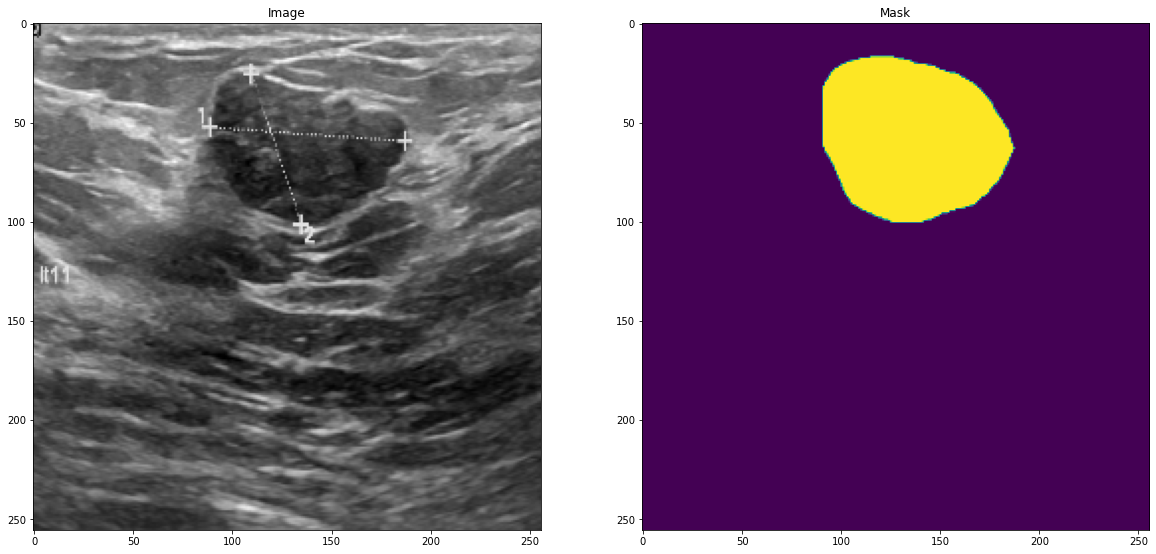

In [10]:
visualize_example(data)

In [11]:
data['image'] = np.array(data['image'])
data['image'].shape

(647, 256, 256, 3)

In [12]:
data['mask'] = np.array(data['mask'])
data['mask'] =  np.expand_dims(data['mask'], -1)
data['mask'].shape

(647, 256, 256, 1)

In [13]:
X_train, X_test, y_train, y_test  = train_test_split(data['image'], data['mask'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(len(X_train), len(y_train), len(X_val), len(y_val),len(X_test), len(y_test))

387 387 130 130 130 130


In [14]:
BASE_FILTERS=16 #base_filter her convolutionda 2 katına çıkacak (farklı bir değerle de başlayabilir 32 gördüm)
INPUT_SIZE=(256,256,3)
DROPOUT      = 0.2
ACTIVATION   = 'relu'
INITIALIZER  = 'he_normal'

input_layer=Input(INPUT_SIZE)

#5 adet katman olacak 256-> 128-> 64->32->16
#bu kısım u-net'teki u şeklinin sol tarafı yani encoder tarafı 

c1 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (input_layer)
c1 = BatchNormalization()(c1)
c1 = Dropout(DROPOUT)(c1)
c1 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(DROPOUT)(c2)
c2 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(DROPOUT)(c3)
c3 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(DROPOUT)(c4)
c4 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(BASE_FILTERS * 16, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(DROPOUT)(c5)
c5 = Conv2D(BASE_FILTERS * 16, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(BASE_FILTERS * 8, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(DROPOUT)(c6)
c6 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(BASE_FILTERS * 4, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(DROPOUT)(c7)
c7 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(BASE_FILTERS * 2, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(DROPOUT)(c8)
c8 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(BASE_FILTERS, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(DROPOUT)(c9)
c9 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c9)


output_layer=Conv2D(1, (1,1), activation='sigmoid')(c9)

model=Model(inputs=[input_layer], outputs=[output_layer])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 256)  0           ['conv2d_transpose[0][0]',       
                                                                  'batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 128)  295040      ['concatenate[0][0]']            
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 128)  512        ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_5 (Dropout)            (None, 32, 32, 128)  0           ['batch_normalization_10[0][0]'] 
          

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',tf.keras.metrics.BinaryIoU(name='IoU')])


In [16]:
callbacks = [
    EarlyStopping(patience=10, verbose=1), 
    ModelCheckpoint('model-checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [17]:
BATCH_SIZE = 16
results = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=18,
    steps_per_epoch=int(np.ceil(len(X_train) / float(16))),
    batch_size=BATCH_SIZE,
    callbacks=callbacks )

Epoch 1/18
25/25 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.7738 - IoU: 0.4252
Epoch 1: val_loss improved from inf to 4.61381, saving model to model-checkpoint.h5
25/25 [==============================] - 162s 6s/step - loss: 0.4998 - accuracy: 0.7738 - IoU: 0.4252 - val_loss: 4.6138 - val_accuracy: 0.7344 - val_IoU: 0.4020
Epoch 2/18
25/25 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.9184 - IoU: 0.5372
Epoch 2: val_loss did not improve from 4.61381
25/25 [==============================] - 154s 6s/step - loss: 0.2426 - accuracy: 0.9184 - IoU: 0.5372 - val_loss: 82.5909 - val_accuracy: 0.2525 - val_IoU: 0.1436
Epoch 3/18
25/25 [==============================] - ETA: 0s - loss: 0.2117 - accuracy: 0.9261 - IoU: 0.6007
Epoch 3: val_loss did not improve from 4.61381
25/25 [==============================] - 154s 6s/step - loss: 0.2117 - accuracy: 0.9261 - IoU: 0.6007 - val_loss: 5.1544 - val_accuracy: 0.3129 - val_IoU: 0.1824
Epoch 4/18


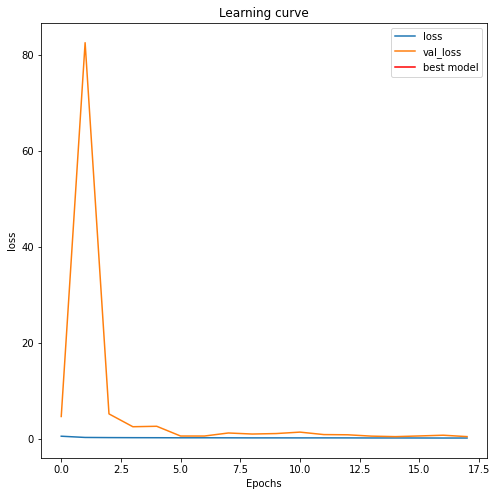

In [18]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

In [19]:
score = model.evaluate(X_test, y_test, verbose = 1) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]*100)

5/5 [==============================] - 8s 2s/step - loss: 0.3626 - accuracy: 0.9194 - IoU: 0.5707
Test loss: 0.3625853359699249
Test accuracy: 91.94064736366272


In [20]:
preds_test = model.predict(X_test, verbose=1)

5/5 [==============================] - 8s 1s/step


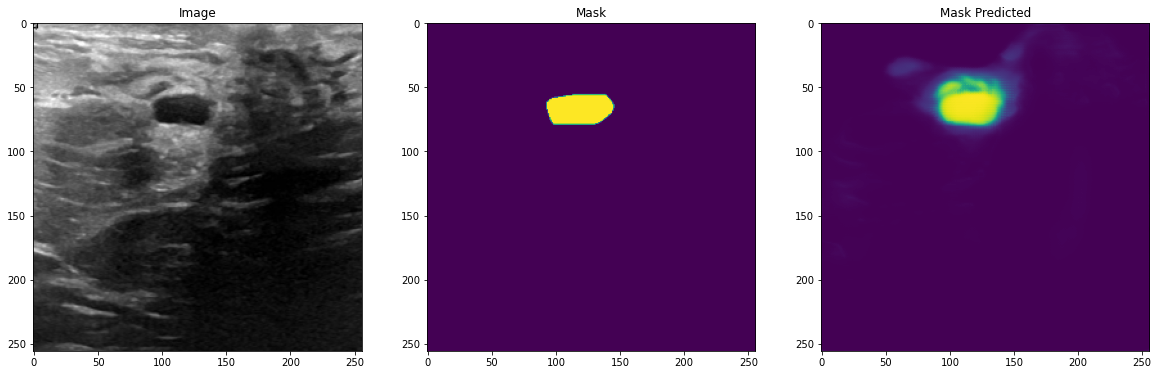

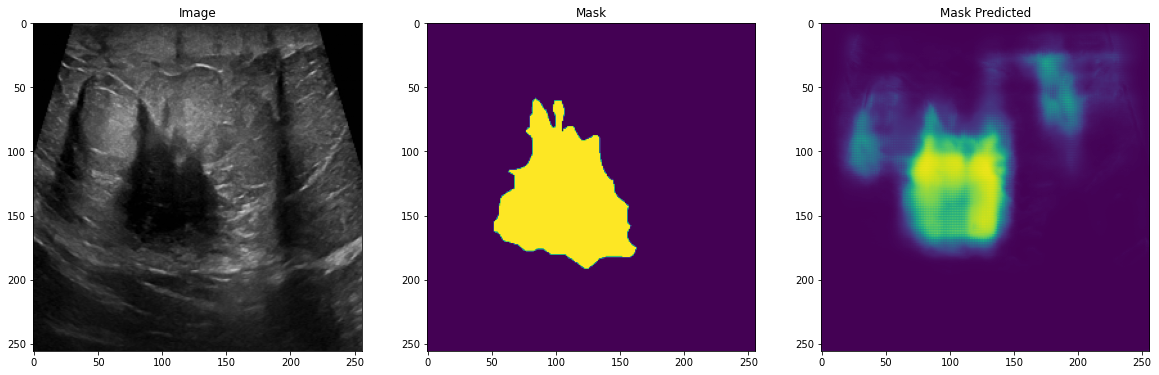

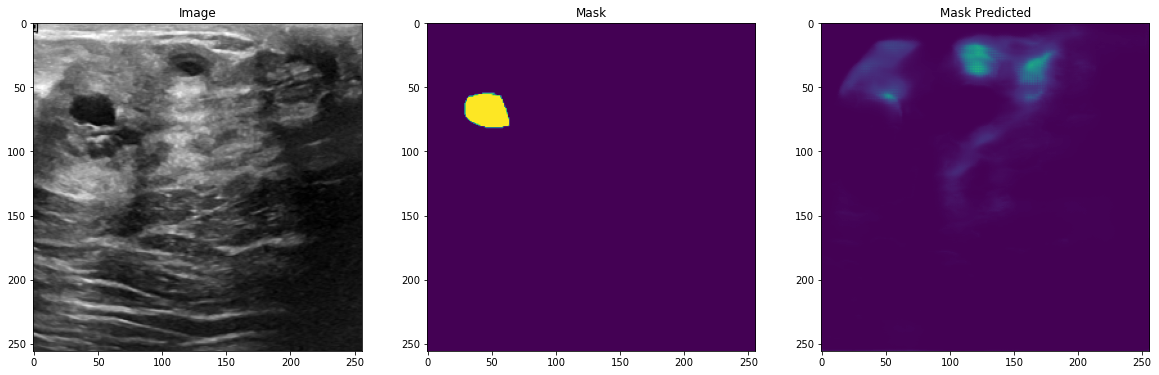

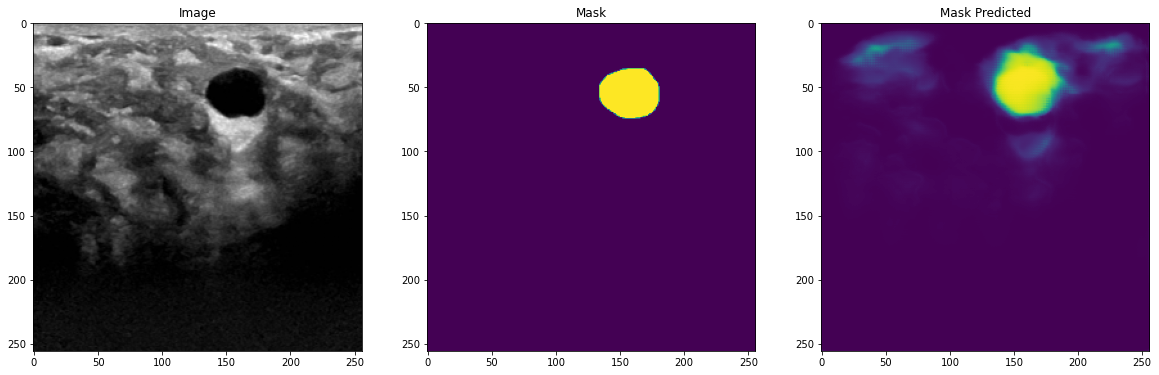

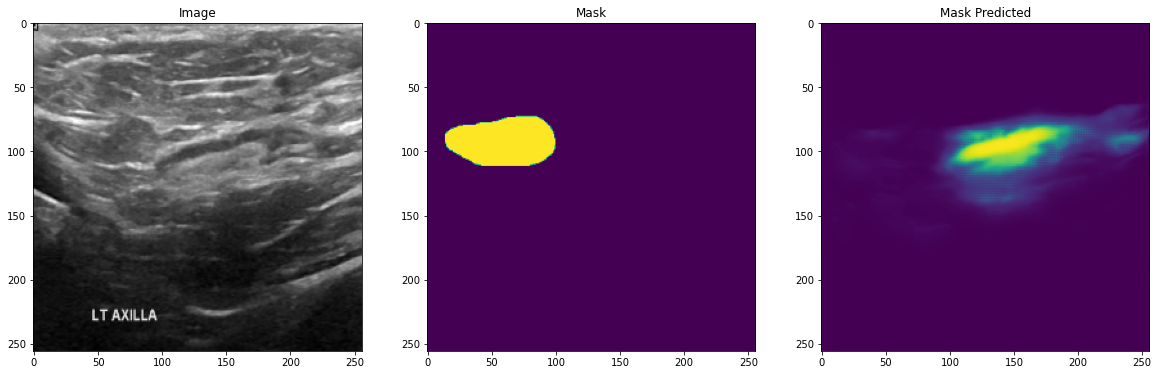

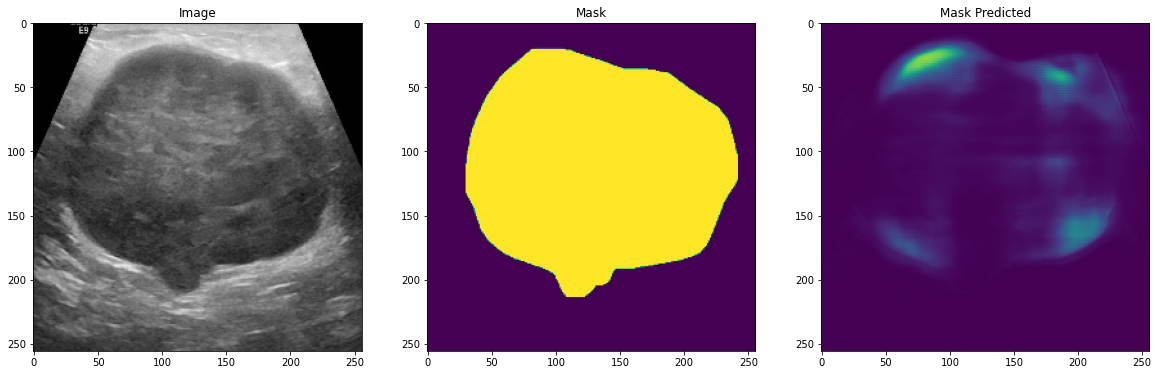

In [31]:
def plot_sample(X, y, preds, ix):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Mask Predicted')
    
plot_sample(X_test, y_test, preds_test, 12)
plot_sample(X_test, y_test, preds_test, 17)
plot_sample(X_test, y_test, preds_test, 32)
plot_sample(X_test, y_test, preds_test, 65)
plot_sample(X_test, y_test, preds_test, 15)
plot_sample(X_test, y_test, preds_test, 96)